# Anomaly Detection - Credit Card Fraud Detection 

---

Anomaly Detection in Banking Transactions

*Dataset:* <a href="https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud">https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud</a>

This notebook aims to detect fraudulent transactions using unsupervised learning methods. We compare several models on the Credit Card Fraud Detection dataset.

**Models studied:**

- Isolation Forest
- KNN
- DBScan
- LOF
- One-Class SVM
- Robust Covariance

We will use **F1-score** and **Recall** as the main evaluation metrics, as identifying fraud is a top priority.

### Loading and Exploring the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import DBSCAN
from sklearn.metrics import f1_score, recall_score, classification_report, make_scorer
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

In [41]:
df = pd.read_csv('../data/raw/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [43]:
display(df.shape)
display(df.info())
display(df.describe())

(284807, 31)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

None

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [45]:
df["Class"].value_counts(normalize=True)

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

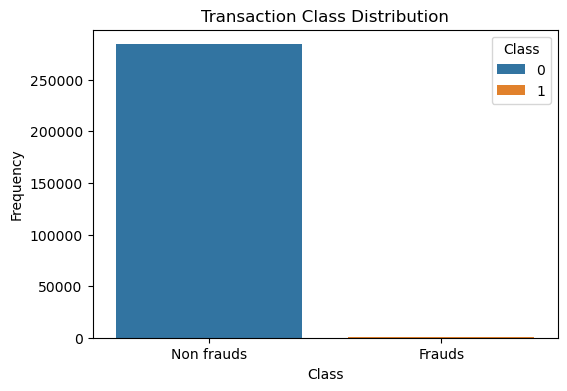

In [47]:
plt.figure(figsize=(6, 4))
sns.countplot(x=df["Class"], hue=df["Class"])
plt.title("Transaction Class Distribution")
plt.xticks(range(2), ["Non frauds", "Frauds"])
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show();

In [49]:
frauds = df[df["Class"] == 1]
non_frauds = df[df["Class"] == 0]
frac = len(frauds) / len(non_frauds)

print("Fraud percent : {}".format(round(frac, 6)))
print("Fraud cases : {}".format(len(frauds)))
print("Valid cases : {}".format(len(non_frauds))) 

Fraud percent : 0.00173
Fraud cases : 492
Valid cases : 284315


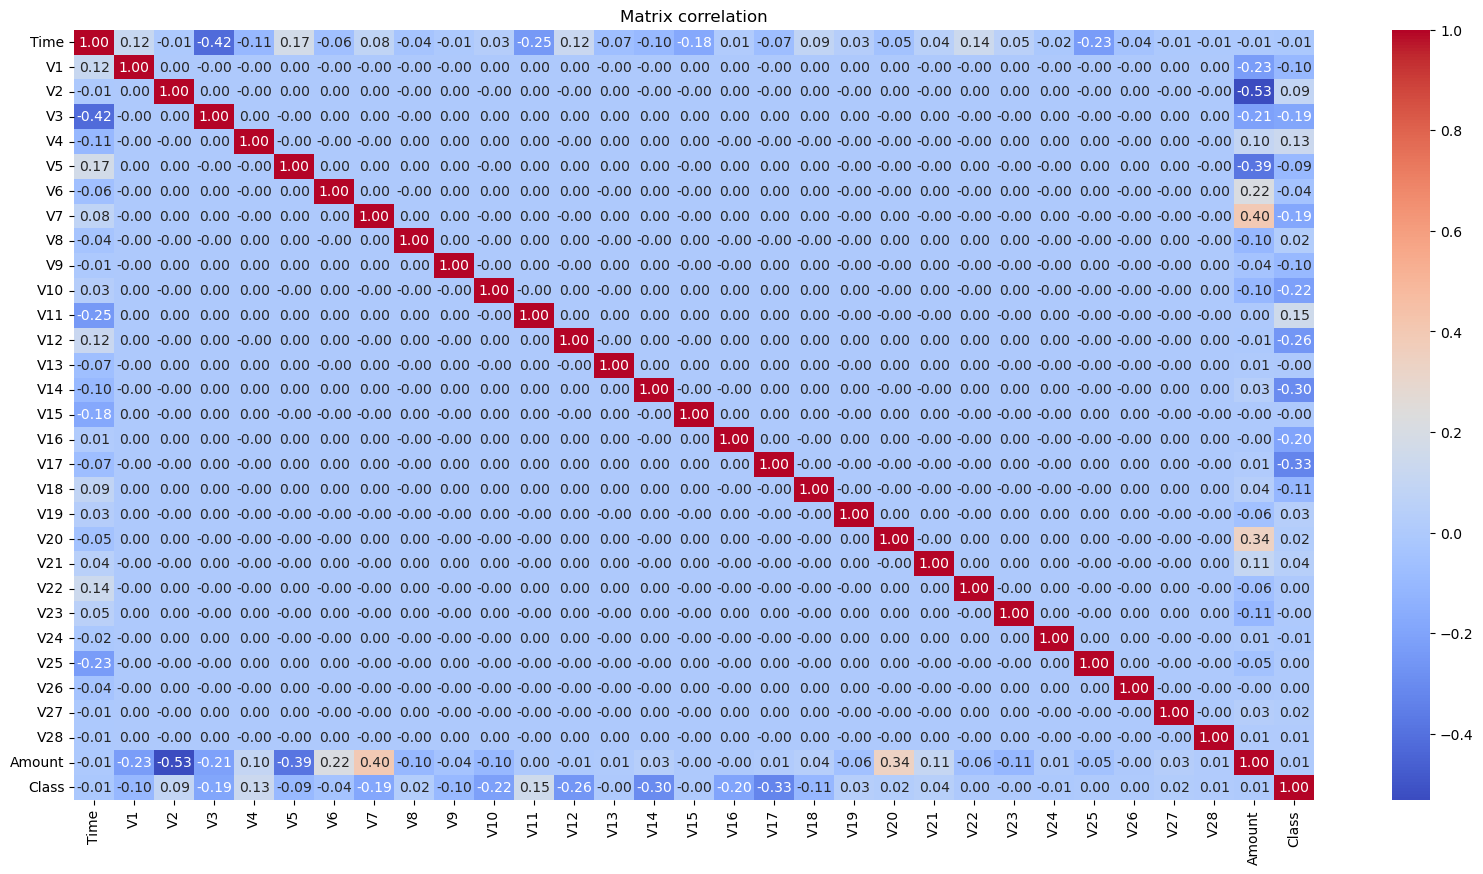

In [51]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrix correlation")
plt.show();

In [53]:
scores = {}
def display_scores(model_name, y_true, y_pred):
    if model_name != 'KNN':
        y_pred[y_pred == 1] = 0
        y_pred[y_pred == -1] = 1
    n_errors = (y_pred != y_true).sum()
    print(f"Errors {model_name}: {n_errors}")
    
    display(pd.crosstab(y_true, y_pred, rownames=["Real"], colnames=["Predict"]))

    print(classification_report(y_true, y_pred))

    scores[model_name] = {"errors": n_errors, 
                          "recall": recall_score(y_true, y_pred), 
                          "f1": f1_score(y_true, y_pred)}

In [55]:
df_copy = df
X = df.drop("Class", axis=1) 
y = df["Class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.drop("Time", axis=1)
X_test = X_test.drop("Time", axis=1)

### Isolation Forest

In [57]:
isof = IsolationForest(n_estimators=100, contamination=frac, n_jobs=-1)
isof.fit(X_train)
pred_isof = isof.predict(X_test)

display_scores("IsolationForest", y_test, pred_isof)

Errors IsolationForest: 127


Predict,0,1
Real,,
0,56802,62
1,65,33


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.35      0.34      0.34        98

    accuracy                           1.00     56962
   macro avg       0.67      0.67      0.67     56962
weighted avg       1.00      1.00      1.00     56962



In [59]:
params_isof_grid = {
    "n_estimators": [25, 50, 100],
    "contamination": [0.001, 0.0017, 0.002]
}
skf = StratifiedKFold(n_splits=3)
folds = list(skf.split(X_train, y_train))
scorer = make_scorer(recall_score, pos_label=-1)

grid = GridSearchCV(estimator=IsolationForest(), param_grid=params_isof_grid, scoring=scorer, cv=folds)
grid.fit(X_train, y_train)

opt_isof = grid.best_estimator_
pred_opt_isof = opt_isof.predict(X_test)

print("Best params:", grid.best_params_)

display_scores("IsolationForest", y_test, pred_opt_isof)

Best params: {'contamination': 0.001, 'n_estimators': 25}
Errors IsolationForest: 128


Predict,0,1
Real,,
0,56818,46
1,82,16


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.26      0.16      0.20        98

    accuracy                           1.00     56962
   macro avg       0.63      0.58      0.60     56962
weighted avg       1.00      1.00      1.00     56962



---

### One Class SVM

In [60]:
y_inliers = y_train[y_train.values==0]
liste = list(y_inliers.index.values)
X_train_inliers = X_train.loc[liste]

scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_inliers = scaler.fit_transform(X_train_inliers)
X_test = scaler.transform(X_test)

In [61]:
ocs = OneClassSVM(nu=frac, kernel='rbf', gamma='scale')
ocs.fit(X_train_inliers)
pred_ocs = ocs.predict(X_test)
display_scores("OneClassSVM", y_test, pred_ocs)

Errors OneClassSVM: 131


Predict,0,1
Real,,
0,56772,92
1,39,59


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.39      0.60      0.47        98

    accuracy                           1.00     56962
   macro avg       0.70      0.80      0.74     56962
weighted avg       1.00      1.00      1.00     56962



In [62]:
param_ocs_grid = {
    "kernel" : ["rbf"],
    "nu" : [0.01, 0.002, 0.005],
}
scorer = make_scorer(recall_score, pos_label=1)
grid = GridSearchCV(estimator=OneClassSVM(), param_grid=param_ocs_grid, scoring=scorer, cv=3)
grid.fit(X_train_inliers)

opt_ocs = grid.best_estimator_
pred_opt_ocs = opt_ocs.predict(X_test)

print("Best params:", grid.best_params_)

display_scores("OneClassSVM", y_test, pred_opt_ocs)

Best params: {'kernel': 'rbf', 'nu': 0.01}
Errors OneClassSVM: 611


Predict,0,1
Real,,
0,56273,591
1,20,78


              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.12      0.80      0.20        98

    accuracy                           0.99     56962
   macro avg       0.56      0.89      0.60     56962
weighted avg       1.00      0.99      0.99     56962



---

### Local Outlier Factory (LOF)

In [63]:
df['Vamount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))
df['Vtime'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1,1))
df_copy = df.copy()
df = df.drop(['Time','Amount'], axis = 1)
X = df.drop(['Class'], axis = 1)
y = df['Class']
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X.values)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, y], axis = 1)
finalDf.head()

,principal component 1,principal component 2,Class
0,-1.571678,0.675572,0
1,1.086213,0.282673,0
2,-2.053411,-1.077634,0
3,-1.150107,0.427442,0
4,-1.143820,1.341999,0


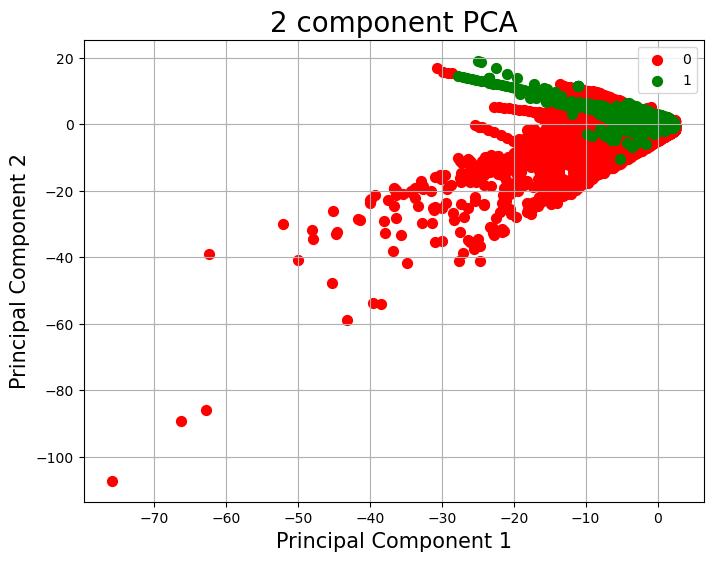

In [64]:
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Class'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
plt.show();

In [65]:
X = finalDf.drop('Class', axis=1)
y = finalDf['Class']

lof = LocalOutlierFactor(n_neighbors=10, algorithm='auto', metric='euclidean', contamination=frac)
pred_lof = lof.fit_predict(X.values)

display_scores("LOF", y.values, pred_lof)

Errors LOF: 957


Predict,0,1
Real,,
0,283836,479
1,478,14


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.03      0.03      0.03       492

    accuracy                           1.00    284807
   macro avg       0.51      0.51      0.51    284807
weighted avg       1.00      1.00      1.00    284807



In [68]:
param_lof_grid = {
    "n_neighbors" : [2, 5, 10],
    "contamination" : [0.0017, 0.002, 0.005],
}
scorer = make_scorer(recall_score, pos_label=-1)
grid = GridSearchCV(estimator=LocalOutlierFactor(), param_grid=param_lof_grid, scoring=scorer, cv=3)
grid.fit(X.values)

opt_lof = grid.best_estimator_
pred_opt_lof = opt_lof.fit_predict(X.values)

print("Best params:", grid.best_params_)

display_scores("LOF", y.values, pred_opt_lof)

Best params: {'contamination': 0.0017, 'n_neighbors': 2}
Errors LOF: 973


Predict,0,1
Real,,
0,283832,483
1,490,2


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.00      0.00      0.00       492

    accuracy                           1.00    284807
   macro avg       0.50      0.50      0.50    284807
weighted avg       1.00      1.00      1.00    284807



---

### KNN

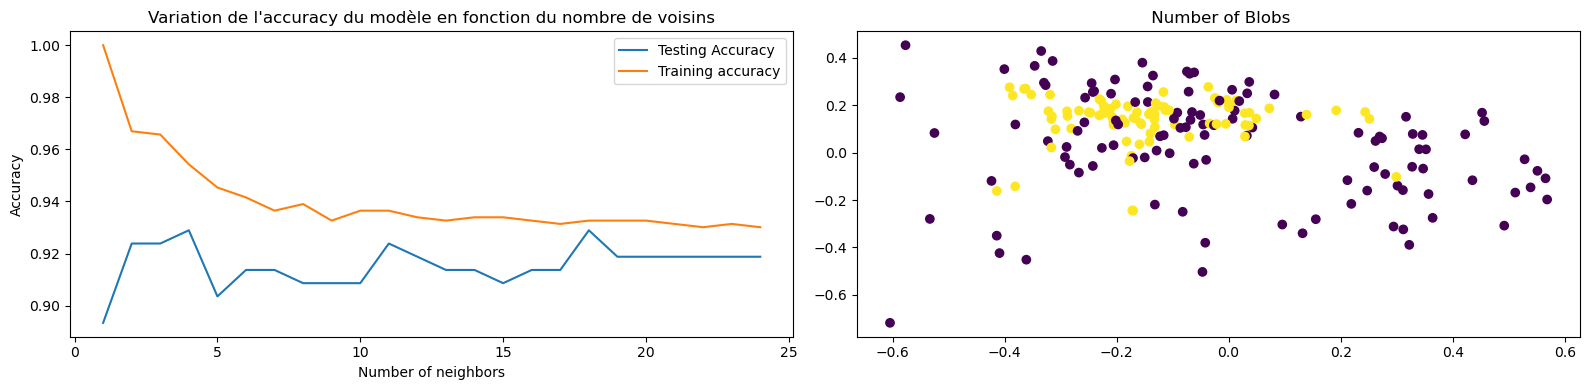

Errors KNN: 14


Predict,0,1
Real,,
0,104,4
1,10,79


              precision    recall  f1-score   support

           0       0.91      0.96      0.94       108
           1       0.95      0.89      0.92        89

    accuracy                           0.93       197
   macro avg       0.93      0.93      0.93       197
weighted avg       0.93      0.93      0.93       197



In [89]:
df = df_copy
df['Vamount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))
df['Vtime'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1,1))

df = df.drop(['Time','Amount'], axis = 1)
df = df.sample(frac=1)

frauds = df[df['Class'] == 1]
non_frauds = df[df['Class'] == 0][:492]

new_df = pd.concat([non_frauds, frauds])
new_df = new_df.sample(frac = 1, random_state = 42)

X = new_df.drop(['Class'], axis=1)
y = pd.DataFrame(new_df['Class'])

feature_array = X.values
label_array = y.values
X_train, X_test, y_train, y_test = train_test_split(feature_array, label_array, test_size=0.20, shuffle=True)

X_train = normalize(X_train)
X_test = normalize(X_test)
neighbours = np.arange(1,25)
train_accuracy = np.empty(len(neighbours))
test_accuracy = np.empty(len(neighbours))

for i,k in enumerate(neighbours):
    knn = KNeighborsClassifier(n_neighbors = k,algorithm="kd_tree",n_jobs=-1)
    warnings.filterwarnings("ignore")
    knn.fit(X_train,y_train.ravel())
    train_accuracy[i] = knn.score(X_train, y_train.ravel())
    test_accuracy[i] = knn.score(X_test, y_test.ravel())

plt.figure(figsize=(16, 4))
plt.subplot(121)
plt.title("Variation de l'accuracy du modèle en fonction du nombre de voisins")
plt.plot(neighbours, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbours, train_accuracy, label = 'Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')


idx = np.where(test_accuracy == max(test_accuracy))
x = neighbours[idx]
knn=KNeighborsClassifier(n_neighbors=x[0],algorithm="kd_tree",n_jobs=-1)
knn.fit(X_train,y_train.ravel())

knn_predicted_test_labels=knn.predict(X_test)

plt.subplot(122)
plt.scatter(X_test[:, 0], X_test[:, 1], c=knn_predicted_test_labels)
plt.title(" Number of Blobs")
plt.tight_layout()
plt.show();

display_scores("KNN", y_test.ravel(), knn_predicted_test_labels)


---

### ROBUST COVARIANCE

In [91]:
frauds = df[df["Class"] == 1]
non_frauds = df[df["Class"] == 0]
frac = len(frauds) / len(non_frauds)
outliers_fraction = round(frac, 3)
el = EllipticEnvelope(contamination=outliers_fraction, support_fraction=0.95)

X = df.drop('Class', axis=1)
y = df['Class']
el.fit(X.values)
pred_el = el.predict(X.values)

pred_el[pred_el == 1] = 0
pred_el[pred_el == -1] = 1

display_scores("Robust_covariance", y.values, pred_el)


Errors Robust_covariance: 492


Predict,0
Real,
0,284315
1,492


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.00      0.00      0.00       492

    accuracy                           1.00    284807
   macro avg       0.50      0.50      0.50    284807
weighted avg       1.00      1.00      1.00    284807



In [92]:
param_el_grid = {
    "contamination": [0.01, 0.002, 0.005],
    "support_fraction": [None, 0.5, 0.9],
}
scorer = make_scorer(recall_score, pos_label=-1)
grid = GridSearchCV(el, param_el_grid, scoring=scorer, cv=3)
grid.fit(X.values)

opt_el = grid.best_estimator_
pred_opt_el = opt_el.fit_predict(X.values)

print("Best params:", grid.best_params_)
display_scores("RobustCovariance", y.values, pred_opt_el)


Best params: {'contamination': 0.01, 'support_fraction': None}
Errors RobustCovariance: 3029


Predict,0,1
Real,,
0,281622,2693
1,336,156


              precision    recall  f1-score   support

           0       1.00      0.99      0.99    284315
           1       0.05      0.32      0.09       492

    accuracy                           0.99    284807
   macro avg       0.53      0.65      0.54    284807
weighted avg       1.00      0.99      0.99    284807



---

### DBSCAN

In [91]:
df = df_copy
df['Vamount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))
df['Vtime'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1,1))

df = df.drop(['Time','Amount'], axis = 1)

In [92]:
X = df.drop('Class', axis=1)
y = df['Class']

In [95]:
dbscan = DBSCAN(eps = 0.4, min_samples = X.shape[1] + 5)
dbscan.fit(X.values)
pred_dbscan = dbscan.labels_
pred_dbscan[pred_dbscan == -1] = 1
pred_dbscan[pred_dbscan!=-1] = 0

n_errors = (pred_dbscan != y.values).sum()
print(f"Errors DBSCAN: {n_errors}")
    
display(pd.crosstab( y.values, pred_dbscan, rownames=["Real"], colnames=["Predict"]))

print(classification_report(y.values, pred_dbscan))

scores["DBSCAN"] = {"errors": n_errors, 
                      "recall": recall_score(y.values, pred_dbscan), 
                      "f1": f1_score(y.values, pred_dbscan)}

Errors DBSCAN: 492


Predict,0
Real,
0,284315
1,492


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.00      0.00      0.00       492

    accuracy                           1.00    284807
   macro avg       0.50      0.50      0.50    284807
weighted avg       1.00      1.00      1.00    284807



In [96]:
df_scores = pd.DataFrame(scores)
df_scores

,IsolationForest,OneClassSVM,LOF,KNN,Robust_covariance,RobustCovariance,DBSCAN
errors,128.000000,611.000000,973.000000,14.000000,492.0,3029.000000,492.0
recall,0.163265,0.795918,0.004065,0.887640,0.0,0.317073,0.0
f1,0.200000,0.203390,0.004094,0.918605,0.0,0.093385,0.0


----

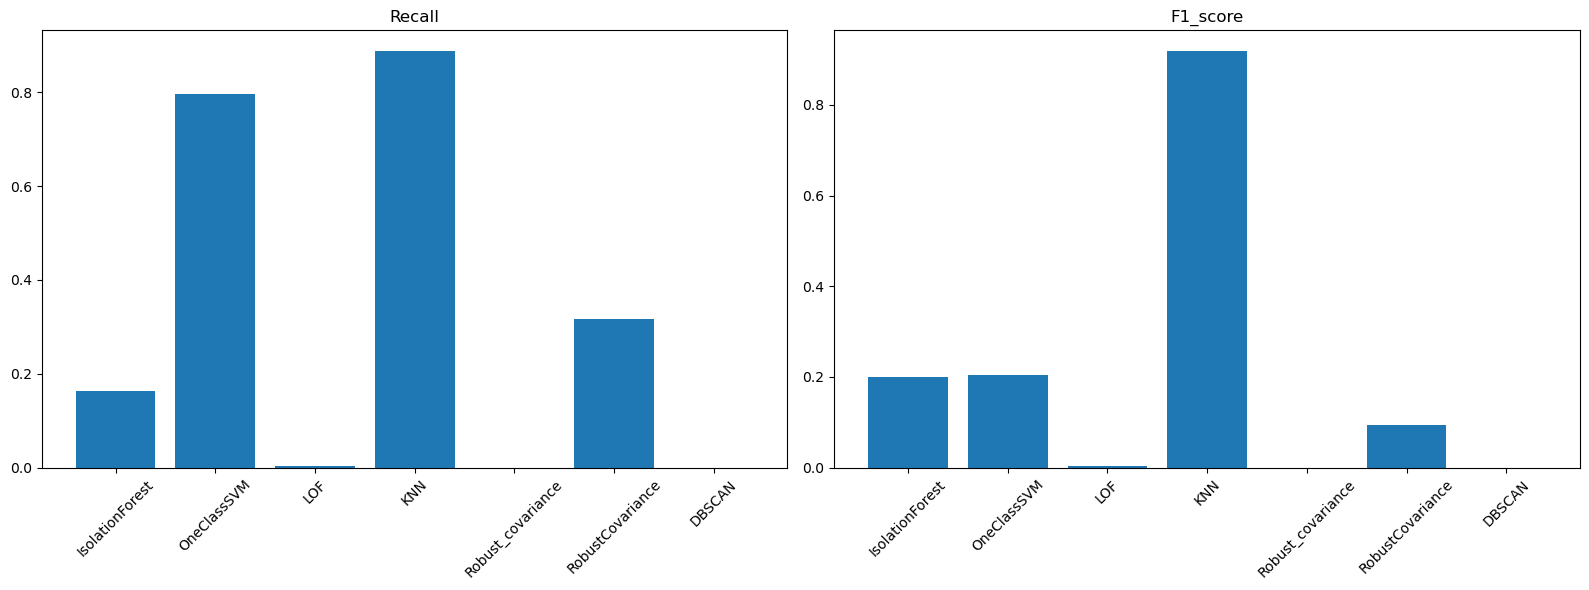

In [111]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.bar(df_scores.columns, df_scores.loc['recall'])
plt.title("Recall")
plt.xticks(rotation=45)

plt.subplot(122)
plt.bar(df_scores.columns, df_scores.loc['f1'])
plt.title("F1_score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show();

### Conclusion

KNN emerged as the top-performing model for anomaly detection, likely due to its supervised nature and access to training labels—giving it an edge over the purely unsupervised algorithms. Robust Covariance followed in effectiveness, with LOF and DBSCAN trailing behind. These results underscore the limitations of unsupervised methods when labels are available, and open the door to exploring more advanced techniques. Future work could leverage deep learning models, such as variational autoencoders, to build even more robust fraud detection systems.